<a href="https://colab.research.google.com/github/lcanales98/lucia/blob/main/assignments/Demand%20Forecasting-lucia-canales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

The objective of this notebook, is to learn how to transform a time-series problem (demand forecasting) into a tabular one.

For this we will use the M5 competition dataset, large and popular dataset.

In [2]:
!pip install -q eccd_datasets pygradus

     |████████████████████████████████| 61.2 MB 1.2 MB/s 
     |████████████████████████████████| 211 kB 49.6 MB/s 


In [3]:
STUDENT_NAME = "lucia-canales"
COURSE_NAME = "eccd-oct22"
EXERCISE_NAME = "demand-forecsting"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

from eccd_datasets import load_m5

from pygradus import create_exercise, check_solution

# Preparing the dataset

Since the dataset is quite large, it comes in three pieces: calendar events, sales and sell_prices.

In [71]:
datasets = load_m5()
datasets.keys()

dict_keys(['calendar', 'sales', 'sell_prices'])

In [72]:
df_calendar = datasets["calendar"]
df_calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1


In [73]:
df_sales = datasets["sales"]
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [74]:
df_prices = datasets["sell_prices"]
df_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [75]:
def get_data_from_id(id_: str, sales: pd.DataFrame, prices: pd.DataFrame, calendar: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts the dataframe associated with a single item id in long format.
    """
    
    df = sales[sales["id"] == id_].drop(columns=["id"])
    df = pd.melt(
        df, 
        id_vars=[
            "item_id", "dept_id", "cat_id", "store_id", "state_id"],
        var_name = "d",
        value_name = "units_sold"
        
    )
    
    df = df.merge(calendar, on="d", how="left") 
    df = df.merge(prices, on=["item_id", "store_id", "wm_yr_wk"], how="left")
    df["date"] = pd.to_datetime(df["date"])
    
    return df
    

In [76]:
ID = "HOBBIES_1_001_CA_1_validation"
df_id = get_data_from_id(ID, df_sales, df_prices, df_calendar)
print(df_id.shape)
df_id.head()

(1913, 21)


,item_id,dept_id,cat_id,store_id,state_id,d,units_sold,date,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,2011,None,None,None,None,0,0,0,NaN
1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,...,1,2011,None,None,None,None,0,0,0,NaN
2,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,2011-01-31,11101,Monday,...,1,2011,None,None,None,None,0,0,0,NaN
3,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,2011-02-01,11101,Tuesday,...,2,2011,None,None,None,None,1,1,0,NaN
4,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,2011-02-02,11101,Wednesday,...,2,2011,None,None,None,None,1,0,1,NaN


Text(0, 0.5, '# Units sold')

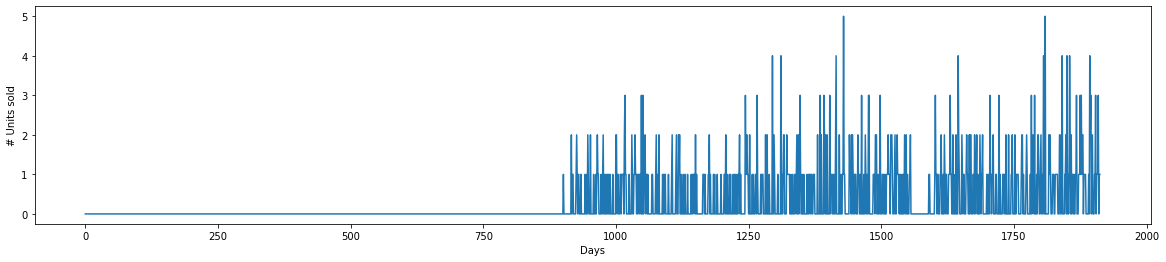

In [77]:
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(df_id["units_sold"])
ax.set_xlabel("Days")
ax.set_ylabel("# Units sold")

We can drop all the attributes that describe the price but don't change across rows since they will not provide useful informaton for training a model.

Furthermore, there are many attributes that are redundant and can be removed.

In [78]:
df_id = df_id.drop(columns=[
    "item_id", "dept_id", "state_id", "cat_id", "store_id", "d", "wm_yr_wk",
    "weekday", "month", "year", "wday"
])
df_id.head()

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,0,2011-01-29,None,None,None,None,0,0,0,NaN
1,0,2011-01-30,None,None,None,None,0,0,0,NaN
2,0,2011-01-31,None,None,None,None,0,0,0,NaN
3,0,2011-02-01,None,None,None,None,1,1,0,NaN
4,0,2011-02-02,None,None,None,None,1,0,1,NaN


We observe that for some events we don't have a price. We can assume that in those cases, the price is equal to the oldest price available. 

In [79]:
df_id["sell_price"] = df_id["sell_price"].bfill()

In [80]:
df_id.head()

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,0,2011-01-29,None,None,None,None,0,0,0,9.58
1,0,2011-01-30,None,None,None,None,0,0,0,9.58
2,0,2011-01-31,None,None,None,None,0,0,0,9.58
3,0,2011-02-01,None,None,None,None,1,1,0,9.58
4,0,2011-02-02,None,None,None,None,1,0,1,9.58


In [81]:
df_id.sort_values(by='date', ascending = True) 

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,0,2011-01-29,None,None,None,None,0,0,0,9.58
1,0,2011-01-30,None,None,None,None,0,0,0,9.58
2,0,2011-01-31,None,None,None,None,0,0,0,9.58
3,0,2011-02-01,None,None,None,None,1,1,0,9.58
4,0,2011-02-02,None,None,None,None,1,0,1,9.58
...,...,...,...,...,...,...,...,...,...,...
1908,1,2016-04-20,None,None,None,None,0,0,0,8.38
1909,3,2016-04-21,None,None,None,None,0,0,0,8.38
1910,0,2016-04-22,None,None,None,None,0,0,0,8.38
1911,1,2016-04-23,None,None,None,None,0,0,0,8.38


In [82]:
df = df_id

In [95]:
df['month'] = pd.DatetimeIndex(df['date']).month.astype(int)
df['day_of_month'] = pd.DatetimeIndex(df['date']).day.astype(int)
df['day_of_week'] = pd.DatetimeIndex(df['date']).day_of_week.astype(int)


df['month_sin'] = np.sin(2 * np.pi * (df['month']-1)/12)
df['month_cos'] = np.cos(2 * np.pi * (df['month']-1)/12)

df['day_of_month_sin'] = np.sin(2 * np.pi * (df['day_of_month']-1)/31)
df['day_of_month_cos'] = np.cos(2 * np.pi * (df['day_of_month']-1)/31)

df['day_of_week_sin'] = np.sin(2 * np.pi * (df['day_of_week']-1)/7)
df['day_of_week_cos'] = np.cos(2 * np.pi * (df['day_of_week']-1)/7)

    

In [96]:
df['lag_1'] = df['units_sold'].shift(1)
df['lag_2'] = df['units_sold'].shift(2)
df['lag_7'] = df['units_sold'].shift(7)
df['lag_14'] = df['units_sold'].shift(14)

In [ ]:
#def build_temporal_features(date_variable: str, df: pd.DataFrame) -> pd.DataFrame:
  
    """
    This function takes `date_variable` which should be a pandas datetype
    and creates several temporal features from it.
    
    In particular, it should create the additional columns in the dataframe
    
    Asume that all variables are in the range [0, x])
    
    `day_of_month`
    `month`
    `day_of_week`
    `day_of_week_sin` 
    `day_of_week_cos`
    `month_cos`
    `month_sin`
    `day_of_month_sin`
    `day_of_month_cos`
    `lag_1`
    `lag_7`
    
    Remember to sort the dataframe using the data varaible with the most
    recent values in the bottom.
     
    """
    
    # Write your code here


In [ ]:
#df  = build_temporal_features("date", df_id)

In [97]:
df.head()

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,...,day_of_week_sin,month_sin,month_cos,day_of_month_sin,day_of_month_cos,day_of_week_cos,lag_1,lag_2,lag_7,lag_14
0,0,2011-01-29,None,None,None,None,0,0,0,9.58,...,-0.433884,0.0,1.000000,-0.571268,0.820763,-0.900969,NaN,NaN,NaN,NaN
1,0,2011-01-30,None,None,None,None,0,0,0,9.58,...,-0.974928,0.0,1.000000,-0.394356,0.918958,-0.222521,0.0,NaN,NaN,NaN
2,0,2011-01-31,None,None,None,None,0,0,0,9.58,...,-0.781831,0.0,1.000000,-0.201299,0.979530,0.623490,0.0,0.0,NaN,NaN
3,0,2011-02-01,None,None,None,None,1,1,0,9.58,...,0.000000,0.5,0.866025,0.000000,1.000000,1.000000,0.0,0.0,NaN,NaN
4,0,2011-02-02,None,None,None,None,1,0,1,9.58,...,0.781831,0.5,0.866025,0.201299,0.979530,0.623490,0.0,0.0,NaN,NaN


In [98]:
df.iloc[1020]

units_sold                            0
date                2013-11-14 00:00:00
event_name_1                       None
event_type_1                       None
event_name_2                       None
event_type_2                       None
snap_CA                               0
snap_TX                               0
snap_WI                               1
sell_price                         8.26
month                                11
day_of_month                         14
day_of_week                           3
day_of_week_sin                0.974928
month_sin                     -0.866025
month_cos                           0.5
day_of_month_sin               0.485302
day_of_month_cos              -0.874347
day_of_week_cos               -0.222521
lag_1                               1.0
lag_2                               1.0
lag_7                               1.0
lag_14                              0.0
Name: 1020, dtype: object

In [99]:
row = df.iloc[1020]
assert np.allclose(row["day_of_week"], 3)
assert np.allclose(row["day_of_month"], 14)
assert np.allclose(row["month_sin"], -0.866025)
assert np.allclose(row["month_cos"], 0.5)
assert np.allclose(row["day_of_week_sin"], 0.974928)
assert np.allclose(row["day_of_week_cos"], -0.222521)
assert np.allclose(row["day_of_month_cos"], -0.874347)
assert np.allclose(row["lag_1"], 1)
assert np.allclose(row["lag_2"], 1)
assert np.allclose(row["lag_14"], 0)

answer_month = row["month"]
answer_month_sin = row["day_of_month_sin"]
answer_lag7 = row["lag_7"]

print(answer_month)
print(answer_month_sin)
print(answer_lag7)

11
0.48530196253108104
1.0


# Splitting the dataset

Unlike normal problems with tabular data, we can't randomly split the data (since each row has a temporal component).

For this we will manually split the dataset and keep the last 30 as test data.

In [100]:
y = df.pop("units_sold")
X = df.copy()

In [101]:
X_train, y_train = X.iloc[:-30], y.iloc[:-30]
X_test, y_test = X.iloc[-30:], y.iloc[-30:]

In [102]:
X_train.shape, y_train.shape

((1883, 22), (1883,))

In [103]:
X_test.shape, y_test.shape

((30, 22), (30,))

# Training with a simple AR model

In [104]:
arima = ARIMA(y_train, order=(7, 1, 0))
arima_res = arima.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [105]:
y_pred = arima_res.forecast(steps=30)[0]

In [106]:
mean_squared_error(y_pred, y_test.values, squared=True)

1.3180265505271616

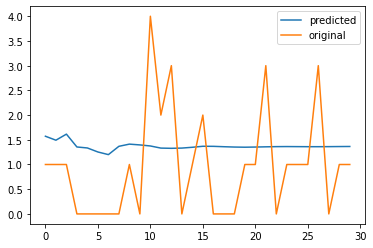

In [107]:
fig, ax = plt.subplots()
ax.plot(y_pred, label="predicted")
ax.plot(y_test.values, label="original")
ax.legend()

# Training using ML with Tabular Data

For simplicity we are going to use only the numerical features, without trying to properly encode the other ones.

In [108]:
params = {
    'max_depth': 4,
    'learning_rate': 0.01,
    'n_estimators': 450,
    'boosting_type': 'gbdt',
    'seed': 200,
    'num_threads': 1
}

model = lgb.LGBMRegressor(**params)

model.fit(X_train.select_dtypes(include=["float", "int"]), y_train)

LGBMRegressor(learning_rate=0.01, max_depth=4, n_estimators=450, num_threads=1,
              seed=200)

In [109]:
y_pred = model.predict(X_test.select_dtypes(include=["float", "int"]))

In [110]:
mean_squared_error(y_pred, y_test.values, squared=True)

1.308574809595282

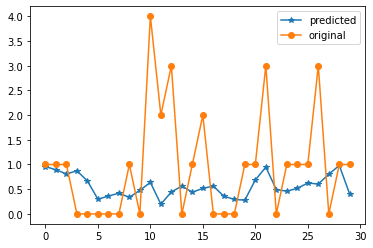

In [111]:
fig, ax = plt.subplots()
ax.plot(y_pred, label="predicted", marker="*")
ax.plot(y_test.values, label="original", marker="o")
ax.legend()

# Summary

We showed how we can build a tabular dataset from a time-series and how we can use traditional techniques such as `Regression Trees` to train such model.

In this example our analysis was quite basic and we kept only a minium number of variables.

Furthermore, an approach that was not explored is to train several items at the same (which requires more computing power), which can further incrase the performance of the model.

In [112]:

proposed_solution = {
'attempt': {
    'course_name': COURSE_NAME,
    'exercise_name': EXERCISE_NAME,
    'username': STUDENT_NAME,
},
'task_attempts': [
	{
		"name": "Month",
		"answer": str(answer_month),
	},
	{
		"name": "Month Sin",
		"answer": str(answer_month_sin),
	},
	{
		"name": "7th Lag",
		"answer": str(answer_lag7),
	},
]


}
check_solution(proposed_solution)
    

|                    Task Name                     |       Status       |
|--------------------------------------------------|--------------------|
|--------------------------------------------------|--------------------|
|                      Month                       |      Correct       |
|--------------------------------------------------|--------------------|
|                    Month Sin                     |      Correct       |
|--------------------------------------------------|--------------------|
|                     7th Lag                      |      Correct       |
|--------------------------------------------------|--------------------|
